In [1]:
import sys; sys.path.insert(0, '../src')
%load_ext autoreload
%autoreload 2

In [45]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import twopass
import changepoints
import tests

plt.rcParams["figure.figsize"] = [8, 3]  # width, height
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.direction'] = 'in'
ids = changepoints.getIds()
eventLog = changepoints.readEventLog()
machineSet = list(changepoints.getMachines(eventLog))

In [19]:
def metricsMachineRuptures(machine, pen, window, algo, graph = False, repeatcalc=False):
    resbyday, logbyday = tests.checkPointsForMachine(name=machine, eventlog=eventLog, ids=ids, influx=False, wirkl_only=True, n_bkps=None, pen=pen, window=window, algo=algo, model="l2", debug=False)
    res = []
    for x in resbyday:
        daywiseX = []
        for y in x:
            daywiseX.append(y)
            #daywiseX.append(y[1])
        res.append(daywiseX)

    metrics = tests.calculateMetrics(res, logbyday, start = True, end = True, customMargin=60)

    labels = list(map(lambda x: str(x["day"]), metrics))
    precision = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]), metrics))
    recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]), metrics))
    alldeviations = []
    for day in metrics:
        alldeviations += day["deviation"]

    if(repeatcalc):
        alldeviations = [] #Abuse alldeviations for all f1 scores
        for x in range(90):
            newmetrics = tests.calculateMetrics(res, logbyday, start = True, end = True, customMargin=90-x)
            prec = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]), newmetrics))
            prec = sum(prec)/len(prec)
            recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]), newmetrics))
            recall = sum(recall)/len(recall)
            f1 = 2*(prec * recall) / (prec + recall) if prec != 0 else 0
            alldeviations.append(f1)


    

    if(graph):

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, precision, width, label='Prec.')
        rects2 = ax.bar(x + width/2, recall, width, label='Recall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by Day for ' + machine + " on " + algo)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()

    return metrics, precision, recall, alldeviations

In [18]:
def metricsMachine(machine, pen, window, algo, graph = False, start = True, end = True, method="Window", mode="dynamic", t=1000, repeatcalc=False):
    resbyday, logbyday = tests.checkpointsMatrixOrDTW(
      name = machine, 
      eventlog = eventLog, 
      ids = ids, 
      influx = False, 
      pen = pen, 
      window = window, 
      algo = algo, 
      interval = "5s", 
      template = "dba", 
      trimming = True, 
      firstpassmethod=method,
      mode=mode,
      t=t,
      debug = False
    )
    res = []
    for x in resbyday:
        daywiseX = []
        for y in x:
            if(start): daywiseX.append(y[0])
            if(end): daywiseX.append(y[1])
        res.append(daywiseX)

    metrics = tests.calculateMetrics(res, logbyday, start = start, end = end, customMargin=60)

    labels = list(map(lambda x: str(x["day"]), metrics))
    precision = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]) if x["TP"] != 0 else 0, metrics))
    recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]) if x["TP"] != 0 else 0, metrics))
    f1score = [2 * (p * r) / (p+r) if p != 0 else 0 for (p,r) in zip(precision, recall)]
    alldeviations = []
    for day in metrics:
        alldeviations += day["deviation"]

    if(repeatcalc):
        alldeviations = [] #Abuse alldeviations for all f1 scores
        for x in range(90):
            newmetrics = tests.calculateMetrics(res, logbyday, start = True, end = True, customMargin=90-x)
            prec = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]), newmetrics))
            prec = sum(prec)/len(prec)
            recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]), newmetrics))
            recall = sum(recall)/len(recall)
            f1 = 2*(prec * recall) / (prec + recall) if prec != 0 else 0
            alldeviations.append(f1)

    if(graph):

        x = np.arange(len(labels))  # the label locations
        width = 0.25  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label='Prec.')
        rects2 = ax.bar(x + width, recall, width, label='Recall')
        rects3 = ax.bar(x, f1score, width, label="F1")

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by Day for ' + machine + " on " + algo)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        ax.bar_label(rects3, padding=3)

        fig.tight_layout()
        #plt.savefig("outrvt/metrics" + machine + mode + method + algo + ".png")
        plt.show()

        ## Histogram
        avgdev = sum(alldeviations)/len(alldeviations)

        plt.suptitle('Changepoint detection deviation, avg=' + str(avgdev))
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.hist(alldeviations, bins=30)
        #plt.savefig("outrvt/deviation" + machine + mode + method + algo + ".png")
        plt.show()

    return metrics, precision, recall, f1score, alldeviations

# Histograms

In [32]:
import json
import statistics

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,20]
algos = ["Window"]

oldres = {}

with open("out/res.json", "r") as infile:
  oldres = json.load(infile)

threshs = {}

with open("outrvt/outresDTWWindow/thresholdsMetrics.json", "r") as infile:
  threshs = json.load(infile)

totaldeviationsT = []

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  for algo in algos:
    metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,"dtw",False,True,True,algo,"statict",threshs[machine][algo][0])
    totaldeviationsT += alldeviations
    print(algo + "DONE")

avgdev = sum(totaldeviationsT)/len(totaldeviationsT)

Starting for HaasMM2
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Done with HaasMM2
WIE IST DAS MÖGLICH
WindowDONE
Starting for Lasebox
Day: 2020 06 22
77 zu 77
77
Kept 10 out of 12
Day: 2020 06 26
11 zu 11
11
Kept 8 out of 10
Day: 2020 06 25
209 zu 209
209
Kept 78 out of 83
Day: 2020 06 24
182 zu 182
182
Kept 47 out of 54
Done with Lasebox
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WindowDONE
Starting for HaasST10
Day: 2020 06 25
90 zu 90
90
Kept 43 out of 65
Day: 2020 06 24
74 zu 74
74
Kept 38 out of 54
Day: 2020 06 22
48 zu 48
48
Kept 21 out of 25
Done with HaasST10
WindowDONE
Starting for cleanlaser
Day: 2020 06 26
40 zu 40
40
Kept 16 out of 21
Day: 2020 06 22
51 zu 51
51
Kept 26 out of 40
Done with cleanlaser
WindowDONE
Starting for Kasto
Day: 2020 

20.895359741714103


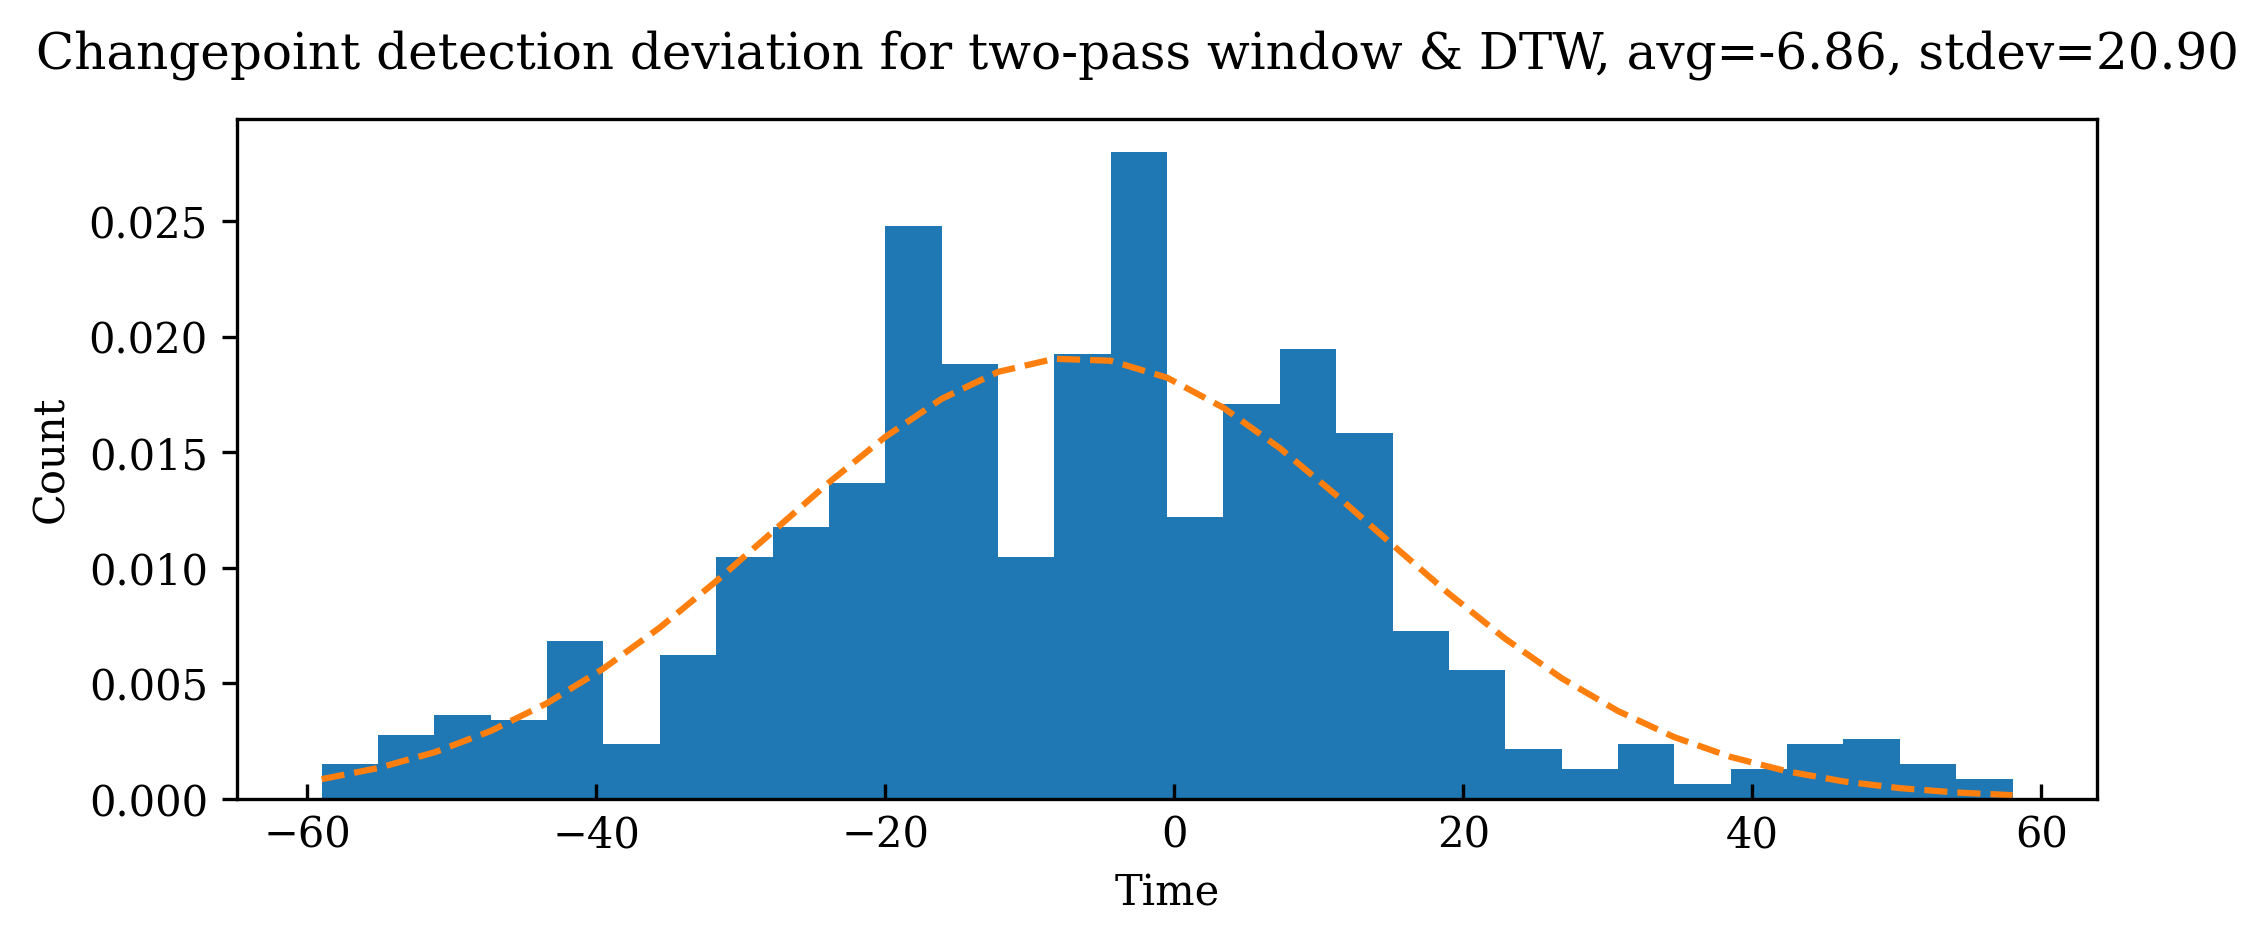

In [6]:
import statistics
import numpy as np

avgdev = sum(totaldeviationsT)/len(totaldeviationsT)
stddev = statistics.stdev(totaldeviationsT)

print(stddev)

plt.suptitle('Changepoint detection deviation for two-pass window & DTW, avg=' + "{:.2f}".format(avgdev) + ", stdev=" + "{:.2f}".format(stddev))
plt.xlabel('Time')
plt.ylabel('Count')
n, bins, patches = plt.hist(totaldeviationsT, bins=30, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * stddev)) * np.exp(-0.5 * (1 / stddev * (bins - avgdev))**2))


plt.plot(bins, y, "--")
#plt.savefig("outrvt/deviation" + machine + mode + method + algo + ".png")
plt.show()

In [36]:
import json

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,20]
algos = ["Window", "Binseg", "Botup"]

totaldeviations = {}
for algo in algos:
  totaldeviations[algo] = []

res = {}

with open("out/res.json", "r") as infile:
  res = json.load(infile)

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  gPens = []
  f1sperAlgo = []

  for algo in algos:
    _,prec,recall,deviations = metricsMachineRuptures(machine=machine, pen=res[algo][ix][3], window=window, algo=algo, graph = False)
    totaldeviations[algo]+=deviations

Done with HaasMM2
Done with HaasMM2
Done with HaasMM2
Done with Lasebox
WIE IST DAS MÖGLICH
Done with Lasebox
WIE IST DAS MÖGLICH
Done with Lasebox
WIE IST DAS MÖGLICH
Done with HaasST10
Done with HaasST10
Done with HaasST10
Done with cleanlaser
Done with cleanlaser
Done with cleanlaser
Done with Kasto
Done with Kasto
Done with Kasto


20.895359741714103


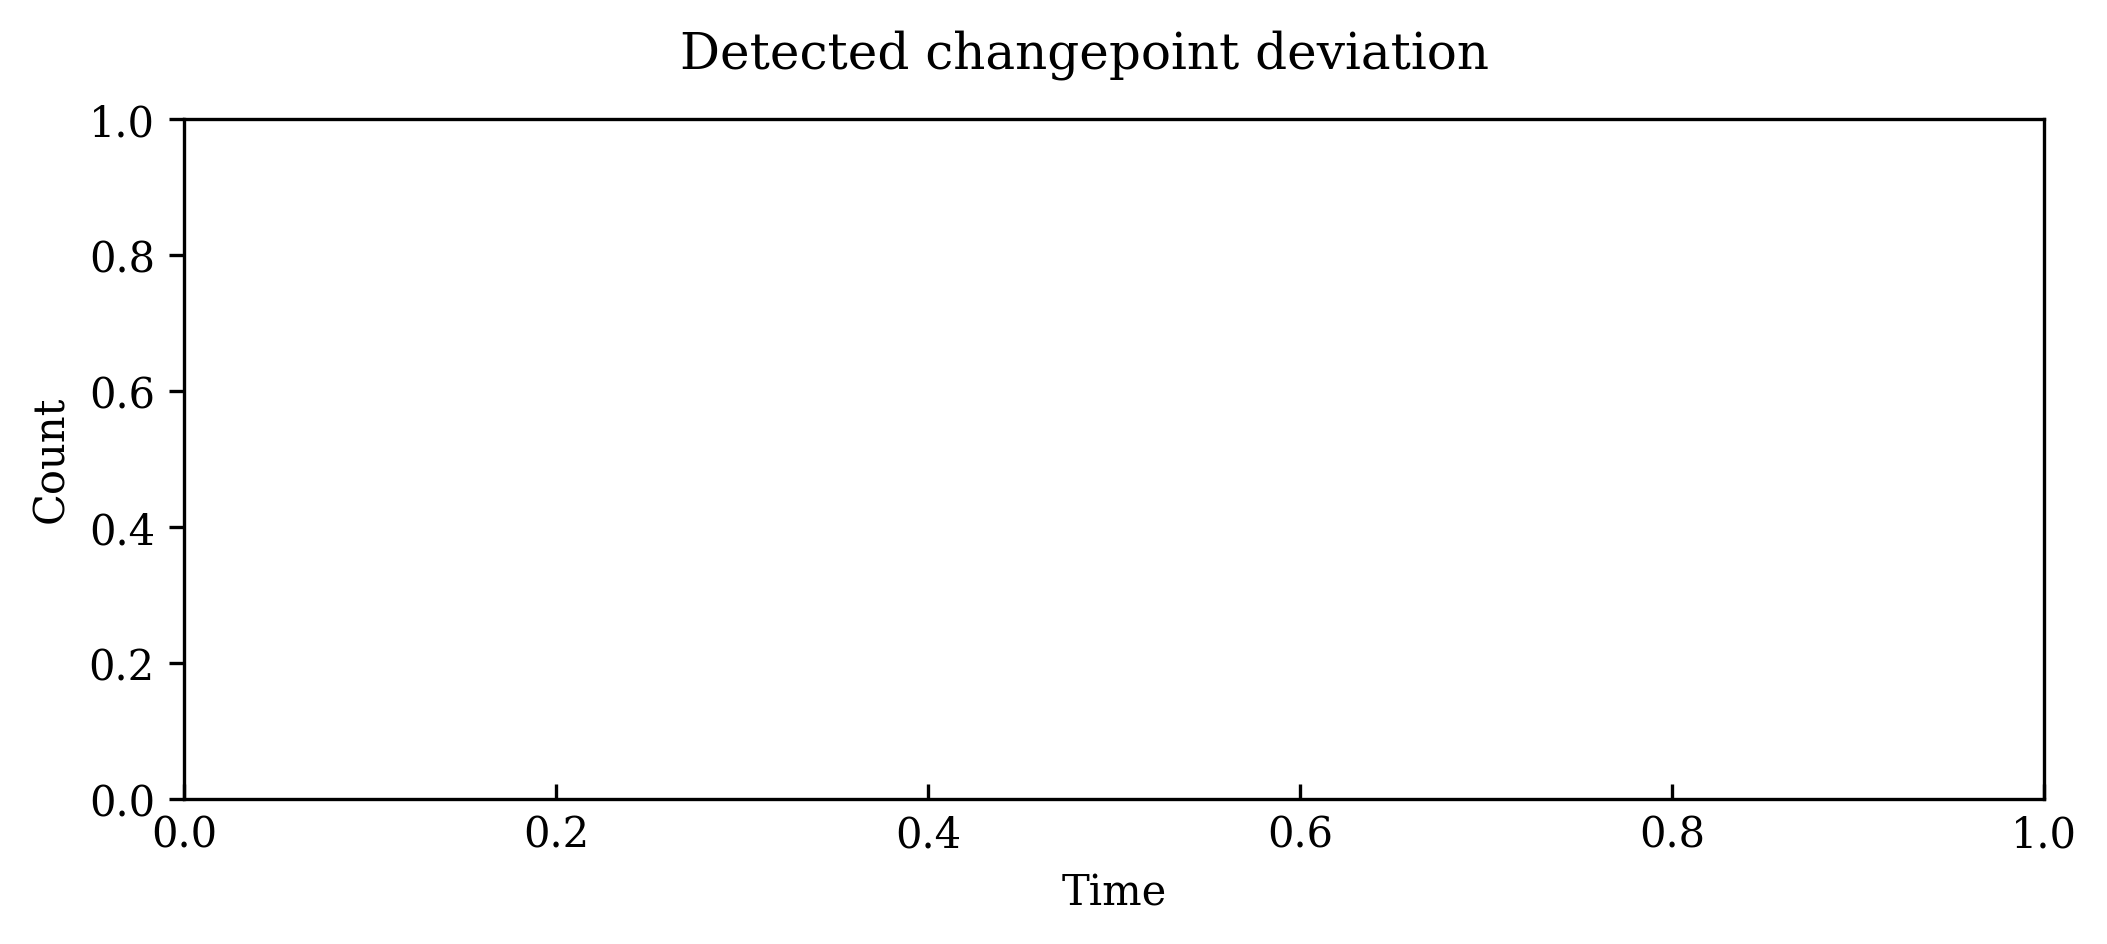

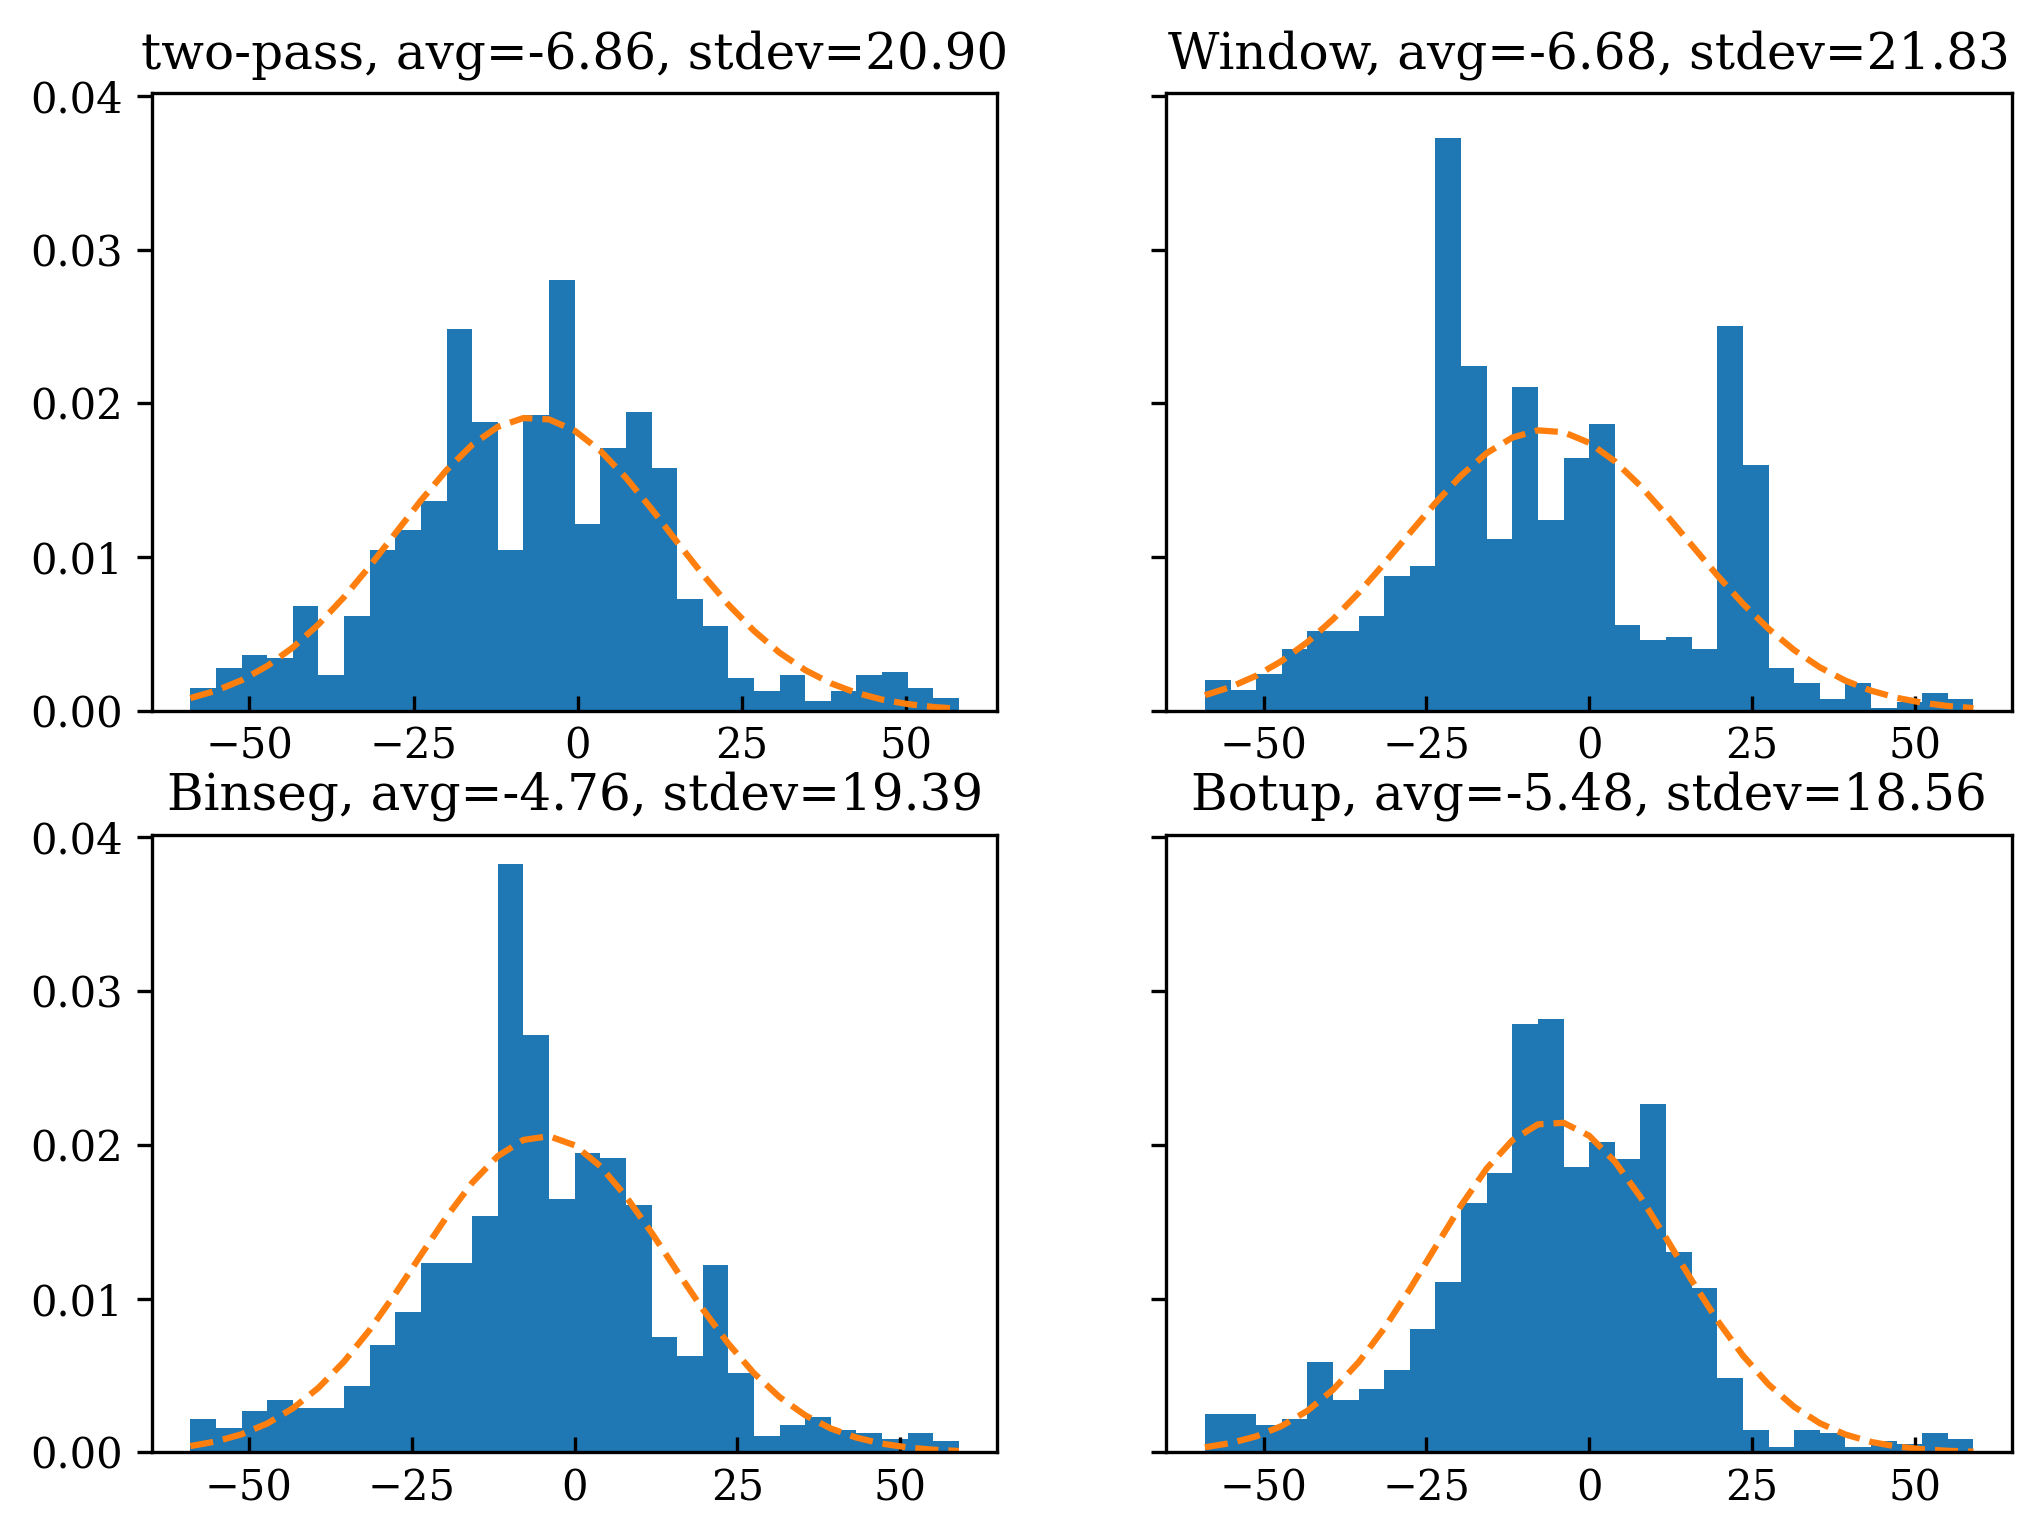

In [50]:
import statistics
import numpy as np

avgdev = sum(totaldeviationsT)/len(totaldeviationsT)
stddev = statistics.stdev(totaldeviationsT)

print(stddev)

plt.suptitle('Detected changepoint deviation')
plt.xlabel('Time')
plt.ylabel('Count')
fig, axs = plt.subplots(2, 2, figsize=(8,6), sharey=True)

axs[0][0].set_title("two-pass, avg=" + "{:.2f}".format(avgdev) + ", stdev=" + "{:.2f}".format(stddev))
n, bins, patches = axs[0][0].hist(totaldeviationsT, bins=30, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * stddev)) * np.exp(-0.5 * (1 / stddev * (bins - avgdev))**2))
axs[0][0].plot(bins, y, "--")

for ix, algo in enumerate(algos):
  avgdev = sum(totaldeviations[algo])/len(totaldeviations[algo])
  stddev = statistics.stdev(totaldeviations[algo])

  axs[0 if ix == 0 else 1][0 if ix == 1 else 1].set_title(algo+", avg=" + "{:.2f}".format(avgdev) + ", stdev=" + "{:.2f}".format(stddev))
  #plt.suptitle('Changepoint detection deviation for two-pass window & DTW, avg=' + "{:.2f}".format(avgdev) + ", stdev=" + "{:.2f}".format(stddev))
  n, bins, patches = axs[0 if ix == 0 else 1][0 if ix == 1 else 1].hist(totaldeviations[algo], bins=30, density=True)
  y = ((1 / (np.sqrt(2 * np.pi) * stddev)) * np.exp(-0.5 * (1 / stddev * (bins - avgdev))**2))
  axs[0 if ix == 0 else 1][0 if ix == 1 else 1].plot(bins, y, "--")


#plt.savefig("outrvt/deviation" + machine + mode + method + algo + ".png")
plt.show()


# Decreasing Margin

In [25]:
import json
import statistics

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,20]
algos = ["Window"]

oldres = {}

with open("out/res.json", "r") as infile:
  oldres = json.load(infile)

threshs = {}

with open("outrvt/outresDTWWindow/thresholdsMetrics.json", "r") as infile:
  threshs = json.load(infile)

totaldeviations = []

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  for algo in algos:
    metrics, precision, recall, f1score, alldeviations = metricsMachine(machine,pens[ix],window,"dtw",False,True,True,algo,"statict",threshs[machine][algo][0], True)
    if(len(totaldeviations) == 0):
      totaldeviations = alldeviations
    else:
      totaldeviations = [sum(x) for x in zip(totaldeviations, alldeviations)]
    print(algo + "DONE")
totaldeviations = [x/len(good_machines) for x in totaldeviations]

Starting for HaasMM2
Day: 2020 06 25
106 zu 106
106
Kept 45 out of 48
Day: 2020 06 24
104 zu 104
104
Kept 41 out of 42
Day: 2020 06 22
51 zu 51
51
Kept 20 out of 22
Done with HaasMM2
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WindowDONE
Starti

In [26]:
import json

good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
pens = [10,0,10,10,20]
algos = ["Window", "Binseg", "Botup"]

totaldeviationsC = {}
for algo in algos:
  totaldeviationsC[algo] = []

res = {}

with open("out/res.json", "r") as infile:
  res = json.load(infile)

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  gPens = []
  f1sperAlgo = []

  for algo in algos:
    _,prec,recall,deviations = metricsMachineRuptures(machine=machine, pen=res[algo][ix][3], window=window, algo=algo, graph = False, repeatcalc=True)
    if(len(totaldeviationsC[algo]) == 0):
      totaldeviationsC[algo] = deviations
    else:
      totaldeviationsC[algo] = [sum(x) for x in zip(totaldeviationsC[algo], deviations)]

for algo in algos:
  totaldeviationsC[algo] = [x/len(good_machines) for x in totaldeviationsC[algo]]

Done with HaasMM2
Done with HaasMM2
Done with HaasMM2
Done with Lasebox
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
Done with Lasebox
WIE IST DAS MÖGLICH
WIE IST DAS MÖGLICH
WIE IST DA

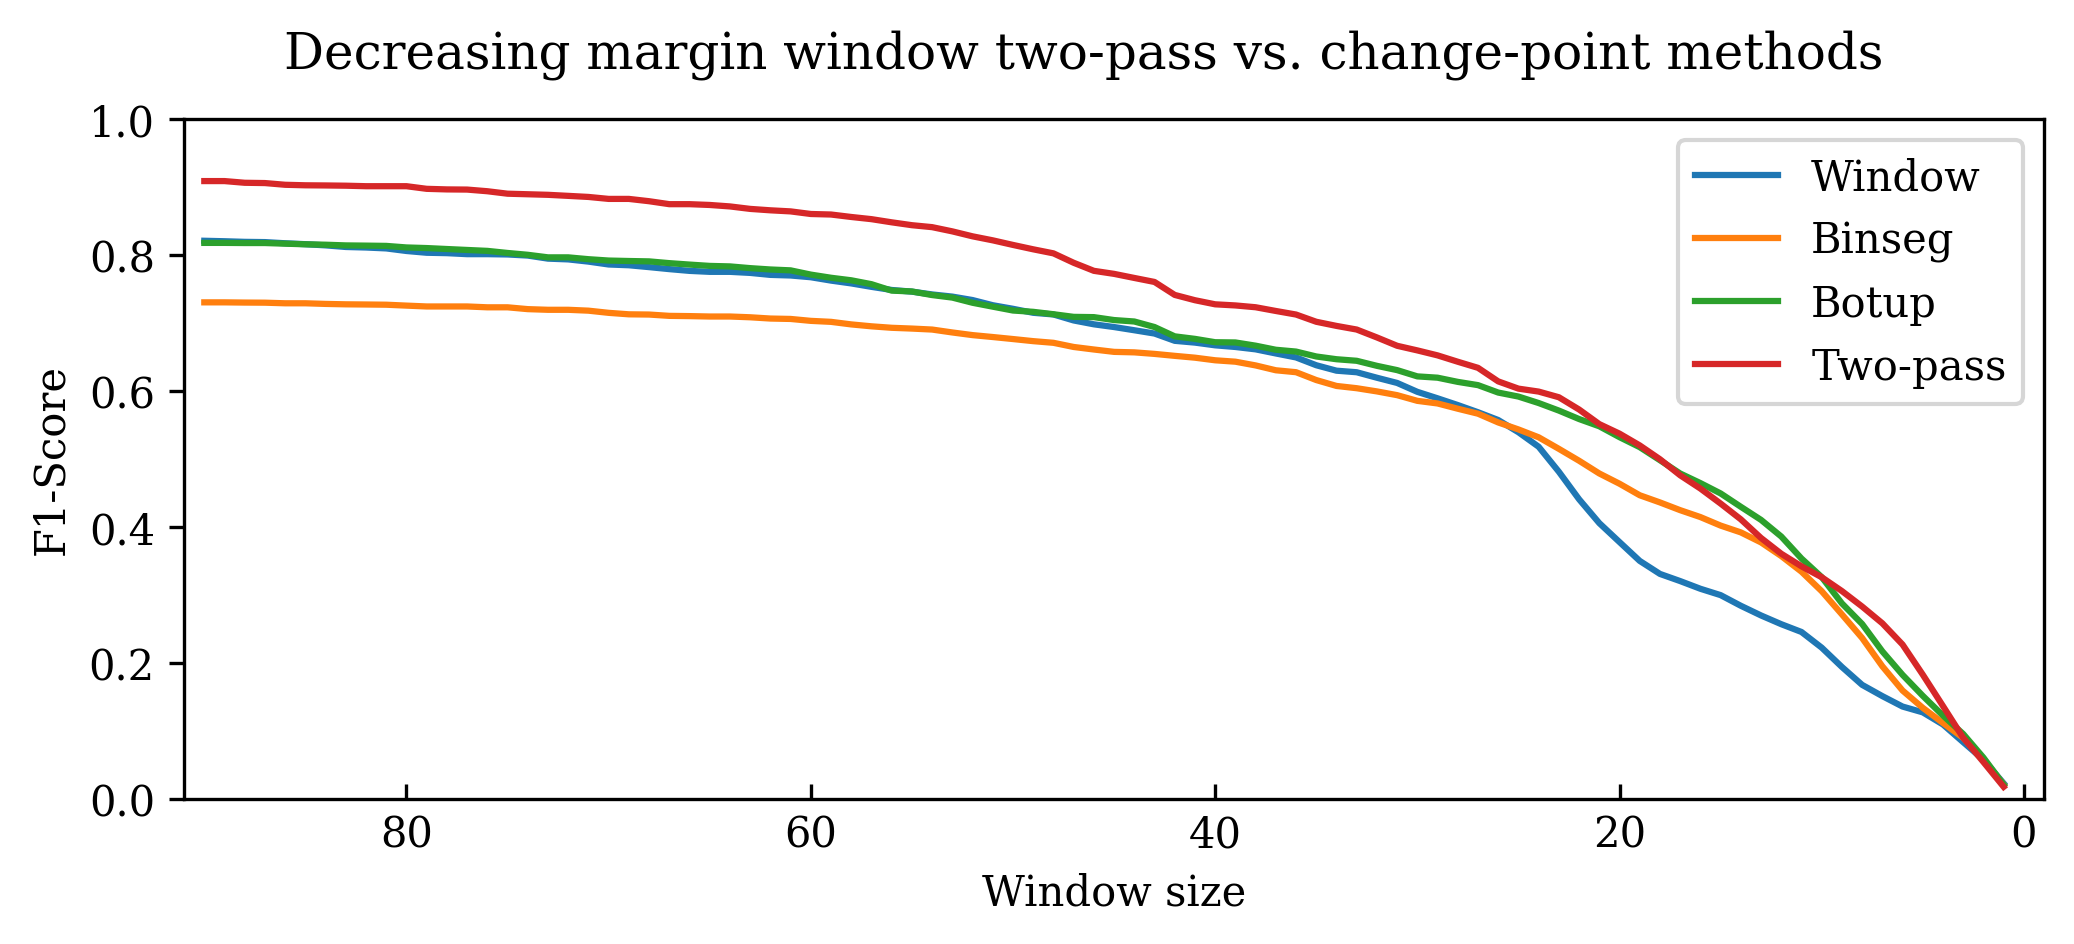

In [31]:
plt.suptitle("Decreasing margin window two-pass vs. change-point methods")
plt.xlabel('Window size')
plt.ylabel('F1-Score')
for algo in algos:
  plt.plot([90-x for x in range(90)], totaldeviationsC[algo], label=algo)
plt.plot([90-x for x in range(90)], totaldeviations, label="Two-pass")
plt.legend()
plt.xlim(91,-1)
plt.ylim(0,1)
#plt.xticks(range(len(pens)), pens, rotation=45)
#plt.savefig("./outrvt/outresDTWWindow/F1score" + good_machines[ix] + ".png")
plt.show()

#print(json.dumps(totaldeviationsC))